In [50]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re

## Connect to db

In [51]:
# connect to mysql database

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="",
    database="halofilkom_db"
)

print(mydb)

In [52]:
# create cursor object
mycursor = mydb.cursor()

## Ambil semua data dari canned response

In [53]:
mycursor.execute("SELECT * FROM `ost_canned_response`")
result = mycursor.fetchall()

In [54]:
# import sql result to pandas dataframe
import pandas as pd
df = pd.DataFrame(result)
df.drop(columns=[0,1,2,5,6,7,8],inplace=True) #drop kolom yang tidak diperlukan
df.columns = ['topik','jawaban']
df.head(10)

,topik,jawaban
0,Keuangan - Pengajuan Bantuan Keuangan,<p>Pengajuan Bantuan Keuangan dapat mengisi fo...
1,Keuangan - Pencairan Saldo UKT,<ol><li>Silahkan mengajukan permohonan pencair...
2,keuangan - cek siam untuk tagihan,"<p>Update Tagihan pada SIAM sdra, apabila Besa..."
3,Keuangan - Kriteria 50%,<p>Kriteria yang mendapat bantuan 50% adalah b...
4,Registrasi Mahasiswa Lama,<p>Berikut kami informasikan Registrasi Mahasi...
5,Keuangan - Jadwal Bantuan Keuangan,<p>Jadwal Bantuan Keuangan Mahasiswa Lama dapa...
6,Keuangan : Tata Cara Pembayaran,"<p>Untuk melakukan pembayaran UKT, SPP, IPI da..."
7,Keuangan - Banding UKT Mahasiswa,<p>Banding tersebut merupakan program dari KBM...
8,Keuangan : Terlambat Pengajuan Bantuan Keuangan,<p>Untuk permohonan pengurangan UKT dilakukan ...
9,Keuangan - Pencairan Beasiswa Kemendikbud,<p>Silahkan membuat surat dilampiri bukti baya...


## Cleaning data

In [55]:
df['jawaban'] = df['jawaban'].apply(lambda x: x.
                                    replace('<p>','').
                                    replace('</p>','').
                                    replace('<ol>','').
                                    replace('</ol>','').
                                    replace('<li>','').
                                    replace('</li>','').
                                    replace('<ul>','').
                                    replace('</ul>','').
                                    replace('<br>','').
                                    replace('br','').
                                    replace('<strong>','').
                                    replace('</strong>','').
                                    replace('<em>','').
                                    replace('</em>','').
                                    replace('<a href="','').
                                    replace('">','').
                                    replace('</a>','').
                                    replace('<img src="','').
                                    replace('" alt="','').
                                    replace('" />','').
                                    replace('< />','')
                                    )

In [56]:
print(df.loc[2]['topik'])
print(df.loc[2]['jawaban'])

keuangan - cek siam untuk tagihan
Update Tagihan pada SIAM sdra, apabila Besaran Nominal sudah sesuai Pengajuan sdra silahkan segera melakukan Pembayaran


In [57]:
import re

index_df = 15
full_text = re.sub(r'[^\w\s]', '', df['topik'][index_df].upper())+", "+ df['jawaban'][index_df].lower()
full_text = full_text.strip()
full_text

'KEUANGAN  TAGIHAN UKT POTONGAN 50 MUNCUL KEMBALI, tagihan potongan 50% mahasiswa tingkat akhir yang muncul kembali\xa0merupakan tagihan yang akan dihapuskan setelah proses verifikasi dari universitas jika anda memenuhi semua kriteria yang diberikan.\xa0silahkan cek siam anda secara berkala.'

## Experiment with n=3

In [58]:
import yake

data = []

def extract_keywords(text):
    keywords = yake.KeywordExtractor(lan="en ", n=3)
    return keywords.extract_keywords(text)[0][0]

for i in range(len(df)):
    judul_topik = re.sub(r'[^\w\s]', '', df['topik'][i])
    judul_topik = judul_topik.lower().replace('keuangan','').replace('kemahasiswaan','').replace('akademik','').strip()
    judul_topik = judul_topik.replace('_',' ')
    full_text = judul_topik+", "+ df['jawaban'][i].lower()
    full_text = full_text.strip()
    data.append([judul_topik,extract_keywords(full_text).lower()])

dfKeywords = pd.DataFrame(data,columns=['topik','keywords'])
dfKeywords

,topik,keywords
0,pengajuan bantuan,pengajuan bantuan keuangan
1,pencairan saldo ukt,"bebas,rapi dan sopan"
2,cek siam untuk tagihan,apabila besaran nominal
3,kriteria 50,adalah bagi mahasiswa
4,registrasi mahasiswa lama,registrasi mahasiswa lama
...,...,...
119,alur pasca ujian skripsi,filkom apps masing
120,mhs kritis ujian sblm 21072022 yudisium,penerbitan skl dll
121,ujian skripsi 20212 pendaftaran yudisium non...,sesuai edaran dekan
122,templates dtif,terkait template dtif


In [59]:
sql_q = "SELECT body FROM ost_thread_entry WHERE body LIKE '%pencairan beasiswa kemendikbud%' AND recipients is not null"
mycursor.execute(sql_q)
result = mycursor.fetchall()
for x in result:
    print(x)

('<p>Untuk suratnya silahkan ditujukan kepada Keuangan Universitas Brawijaya, bebas rapi tanpa format khusus dan perihal pencairan beasiswa kemendikbud.\xa0<br /><br />Terima kasih</p>',)
('<p>Terkait dengan Pencairan Beasiswa Kemendikbud, bisa ditanyakan ke haloselma karena semua proses dari Universitas,\xa0<br />dan terkait hasil pengajuan anda sudah\xa0sesuai arahan wakil Dekan II. mohon maaf jika masih berkeberatan silahkan diajukan dengan menuliskan lengkap dengan alasaan anda berikut "Padahal kan itu beasiswa dari Kemendikbud itu buat semester ganjil jadi menurut saya, bantuan beasiswa Kemendikbud seharusnya dikirimkan ke rekening bank mahasiswa bukan ditahan di saldo SIAM UB".<br /></p> <p><br /></p> <p>Terima kasih</p>',)


In [60]:
dfKeywords['keywords']

0      pengajuan bantuan keuangan
1            bebas,rapi dan sopan
2         apabila besaran nominal
3           adalah bagi mahasiswa
4       registrasi mahasiswa lama
                  ...            
119            filkom apps masing
120            penerbitan skl dll
121           sesuai edaran dekan
122         terkait template dtif
123          mohon mahasiswa bisa
Name: keywords, Length: 124, dtype: object

In [61]:
data = []

for i in range(len(dfKeywords)):
    sql_q = "SELECT body FROM ost_thread_entry WHERE body LIKE '%"+dfKeywords['keywords'][i]+"%' AND recipients is null"
    try:
        mycursor.execute(sql_q)
        result = mycursor.fetchall()
        for res in result:
            data.append([dfKeywords['topik'][i],res[0]])
    except:
        print("error")
        print(sql_q)

dfPertanyaan = pd.DataFrame(data,columns=['topik','pertanyaan'])
dfPertanyaan.shape

error
SELECT body FROM ost_thread_entry WHERE body LIKE '%wa'alaykumussalamsekedar menginformasikan bahwa%' AND recipients is null


(1199, 2)

In [62]:
index = 589
print(dfPertanyaan['topik'][index])
print(dfPertanyaan['pertanyaan'][index])

 tombol revisi proposal skripsi pada filkom apps
<p>Selamat siang</p> <p>Saya Rizky F Revaldy, mahasiswa Teknik Informatika ingin bertanya, pada Filkom Apps keterangan skripsi saya adalah verifikasi dan disuruh menghubungi operator akademik. Bagaimana cara saya untuk menghubungi operator akademiknya? Terima kasih banyak sebelumnya</p>


### Analisa Hasil

In [63]:
dfPertanyaan

,topik,pertanyaan
0,pengajuan bantuan,<p>Terima kasih atas jawaban yang bapak/ibu be...
1,pengajuan bantuan,<p>Saya sudah melakukan pengajuan bantuan keua...
2,pengajuan bantuan,<p>Terimakasih bpk/Ibu..</p> <p>sbg informasi ...
3,pengajuan bantuan,<p>Dalam proses pengajuan bantuan keuangan unt...
4,pengajuan bantuan,<p>Mohon maaf yang dimaksud dengan Akumulasi i...
...,...,...
1194,kkn 2020,"<p>Permisi, mohon maaf apabila mengganggu wakt..."
1195,kkn 2020,"<p>Saya mau bertanya, di tata tertib UAS tertu..."
1196,kkn 2020,<p>1. dikarenakan rencana pembayaran yang akan...
1197,kkn 2020,<p>Selamat siang. Berikut adalah surat edaran ...


In [64]:
print(dfKeywords['keywords'].unique().shape[0])
print(dfPertanyaan['topik'].unique().shape[0])
print()
print((dfPertanyaan['topik'].unique().shape[0]) / (dfKeywords['keywords'].unique().shape[0]) * 100)

110
59

53.63636363636364


In [65]:
dfg = dfPertanyaan.groupby('topik').count().sort_values(by='pertanyaan',ascending=False)
dfg

,pertanyaan
topik,
tombol revisi proposal skripsi pada filkom apps,182
banding ukt mahasiswa,153
crisis centre uas filkom 20211,66
kip kuliah,58
perubahan judul skripsi filkom apps,54
tagihan ukt potongan 50 muncul kembali,50
syarat menempuh mk lintas prodi,38
tidak bisa mengikuti uas luring dan terpadu,36
foto yudisium,33


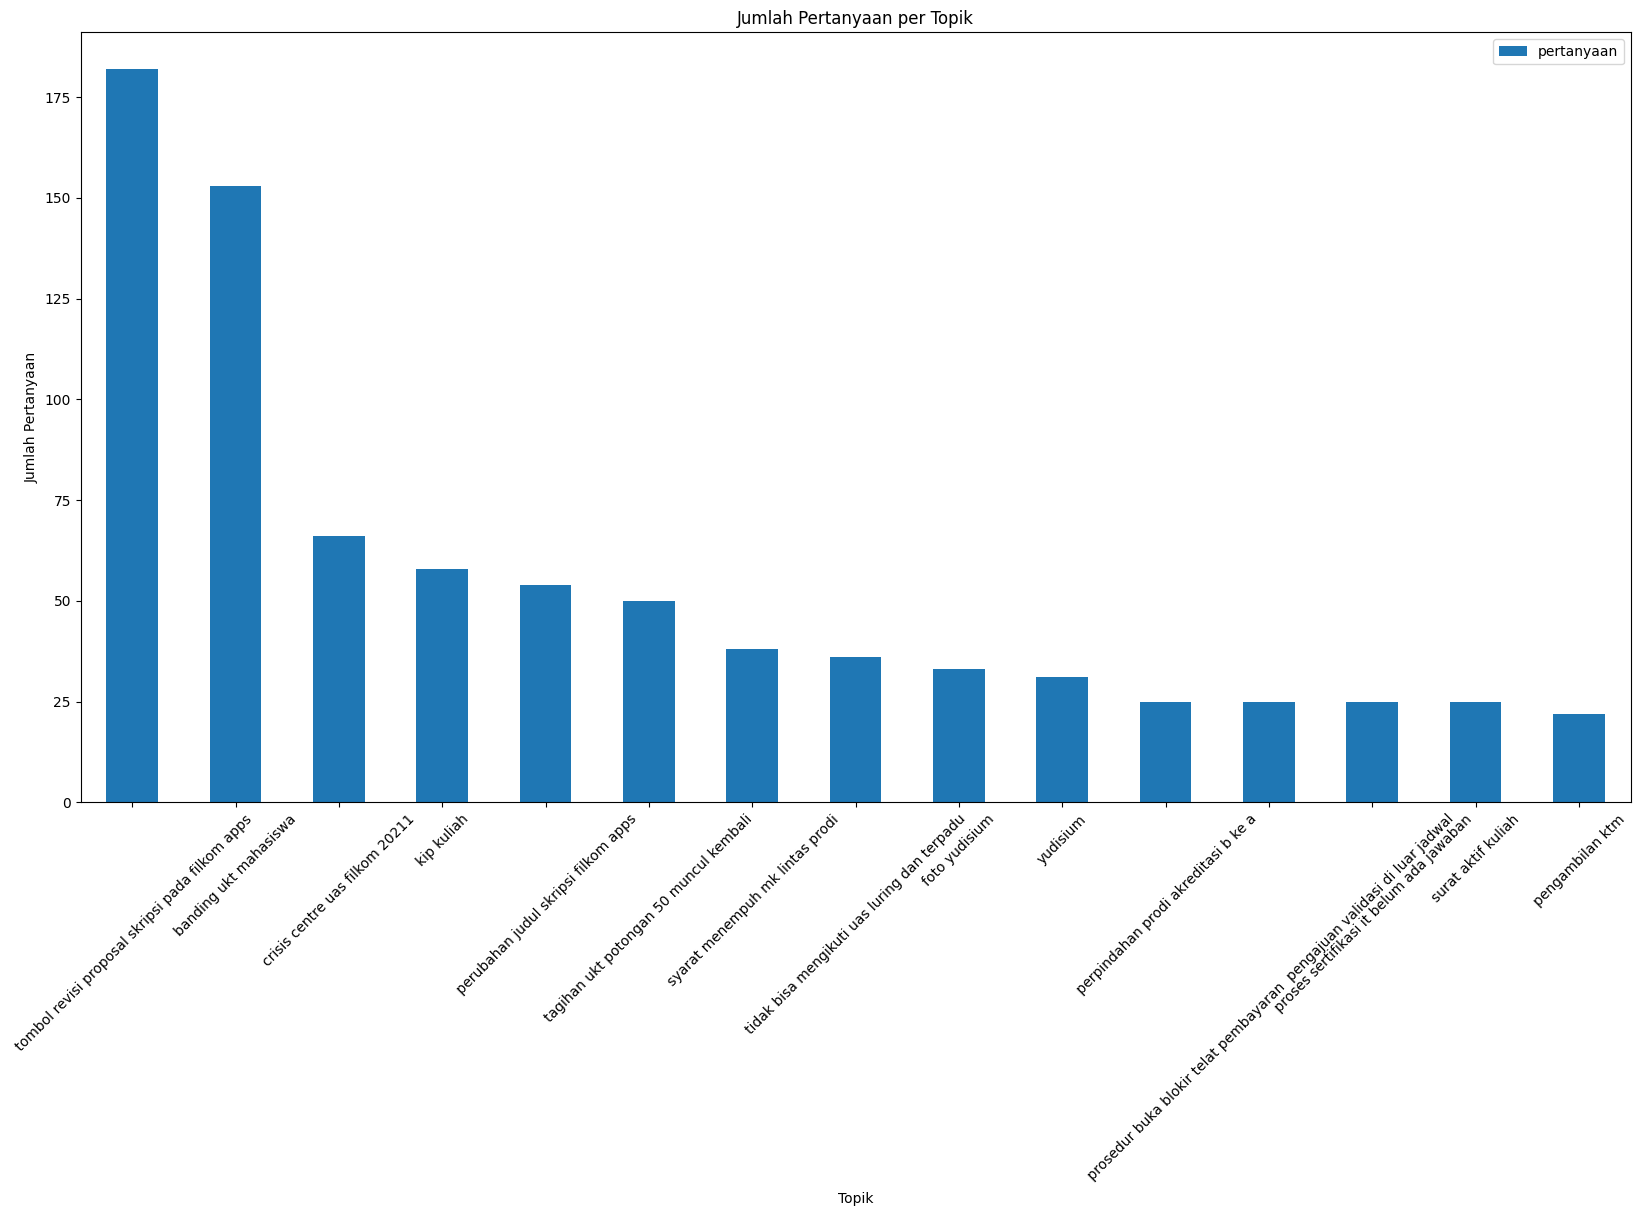

In [66]:
dfp = dfg.head(15).plot(kind='bar',
            figsize=(20,10),
            title='Jumlah Pertanyaan per Topik',
            xlabel='Topik',
            ylabel='Jumlah Pertanyaan',
            rot=45)

In [67]:
fig = dfp.get_figure()
fig.savefig("experiment_n3.png")

## Experiment with n=2

In [68]:
data = []

def extract_keywords(text):
    keywords = yake.KeywordExtractor(lan="en ", n=2)
    return keywords.extract_keywords(text)[0][0]

for i in range(len(df)):
    judul_topik = re.sub(r'[^\w\s]', '', df['topik'][i])
    judul_topik = judul_topik.lower().replace('keuangan','').replace('kemahasiswaan','').replace('akademik','').strip()
    judul_topik = judul_topik.replace('_',' ')
    full_text = judul_topik+", "+ df['jawaban'][i].lower()
    full_text = full_text.strip()
    data.append([judul_topik,extract_keywords(full_text).lower()])

dfKeywords = pd.DataFrame(data,columns=['topik','keywords'])
dfKeywords

,topik,keywords
0,pengajuan bantuan,pengajuan bantuan
1,pencairan saldo ukt,pencairan saldo
2,cek siam untuk tagihan,apabila besaran
3,kriteria 50,adalah bagi
4,registrasi mahasiswa lama,registrasi mahasiswa
...,...,...
119,alur pasca ujian skripsi,filkom apps
120,mhs kritis ujian sblm 21072022 yudisium,tetap diwajibkan
121,ujian skripsi 20212 pendaftaran yudisium non...,menghubungi halofilkom
122,templates dtif,skripsi dll


In [69]:
data = []

for i in range(len(dfKeywords)):
    sql_q = "SELECT body FROM ost_thread_entry WHERE body LIKE '%"+dfKeywords['keywords'][i]+"%' AND recipients is null"
    mycursor.execute(sql_q)
    result = mycursor.fetchall()
    for res in result:
        data.append([dfKeywords['topik'][i],res[0]])

dfPertanyaan = pd.DataFrame(data,columns=['topik','pertanyaan'])
dfPertanyaan.shape

(29356, 2)

In [70]:
dfPertanyaan

,topik,pertanyaan
0,pengajuan bantuan,<p>Semester lalu saya mengajukan bantuan UKT u...
1,pengajuan bantuan,"<p>Assalamualaikum, selamat pagi Bapak/Ibu. Pe..."
2,pengajuan bantuan,<p>Terima kasih atas jawaban yang bapak/ibu be...
3,pengajuan bantuan,"<p>Assalamualaikum pak, saya mau tanya terkait..."
4,pengajuan bantuan,<p>Saya sudah melakukan pengajuan bantuan keua...
...,...,...
29351,ujian skripsi 20212 pendaftaran yudisium non...,"<p>Selamat siang bapak / ibu, bagaimana dengan..."
29352,ujian skripsi 20212 pendaftaran yudisium non...,<p>Assalamualaikum warahmatullahi wb</p> <p>Sa...
29353,ujian skripsi 20212 pendaftaran yudisium non...,"<p>Assalamualaikum Wr. Wb., </p> <p>Selamat pa..."
29354,ujian skripsi 20212 pendaftaran yudisium non...,<p>terima kasih telah menghubungi HaloFilkom</...


In [71]:
index = 589
print(dfPertanyaan['topik'][index])
print(dfPertanyaan['pertanyaan'][index])

pengambilan sertifikat toefl
<p>Selamat pagi pak/bu, Saya terlewat pemberitahuan mengenai bantuan ukt untuk semester ini yang akhir pendaftaran nya pada tanggal 28 Juli ini, karena saya dari kemarin saya sedang dalam PKL, dan yang saya lihat pemberitahuan nya baru keluar tanggal 26, apakah masih ada kesempatan untuk mendaftar pak/bu? Mohon sangat bantuan nya pak/bu, keluarga saya tidak kuat kalau harus membayar full UKT setidaknya didepan, Tolong informasinya dan terima kasih sebelumnya </p>


In [72]:
print(dfKeywords['keywords'].unique().shape[0])
print(dfPertanyaan['topik'].unique().shape[0])
print()
print((dfPertanyaan['topik'].unique().shape[0]) / (dfKeywords['keywords'].unique().shape[0]) * 100)

109
97

88.9908256880734


### Analisa Hasil

In [73]:
dfg = dfPertanyaan.groupby('topik').count().sort_values(by='pertanyaan',ascending=False)
dfg

,pertanyaan
topik,
surat aktif kuliah,6100
pengambilan sertifikat toefl,6100
pengambilan ijazah non prosesi,1692
pengajuan transkrip keperluan beasiswa mhs do semhas validasi kps dll,1692
batas sks beban mhs,1074
...,...
bebas pustaka ub,1
bebas tanggungan laboratorium filkom ub,1
surat pengantar penelitian skripsi,1


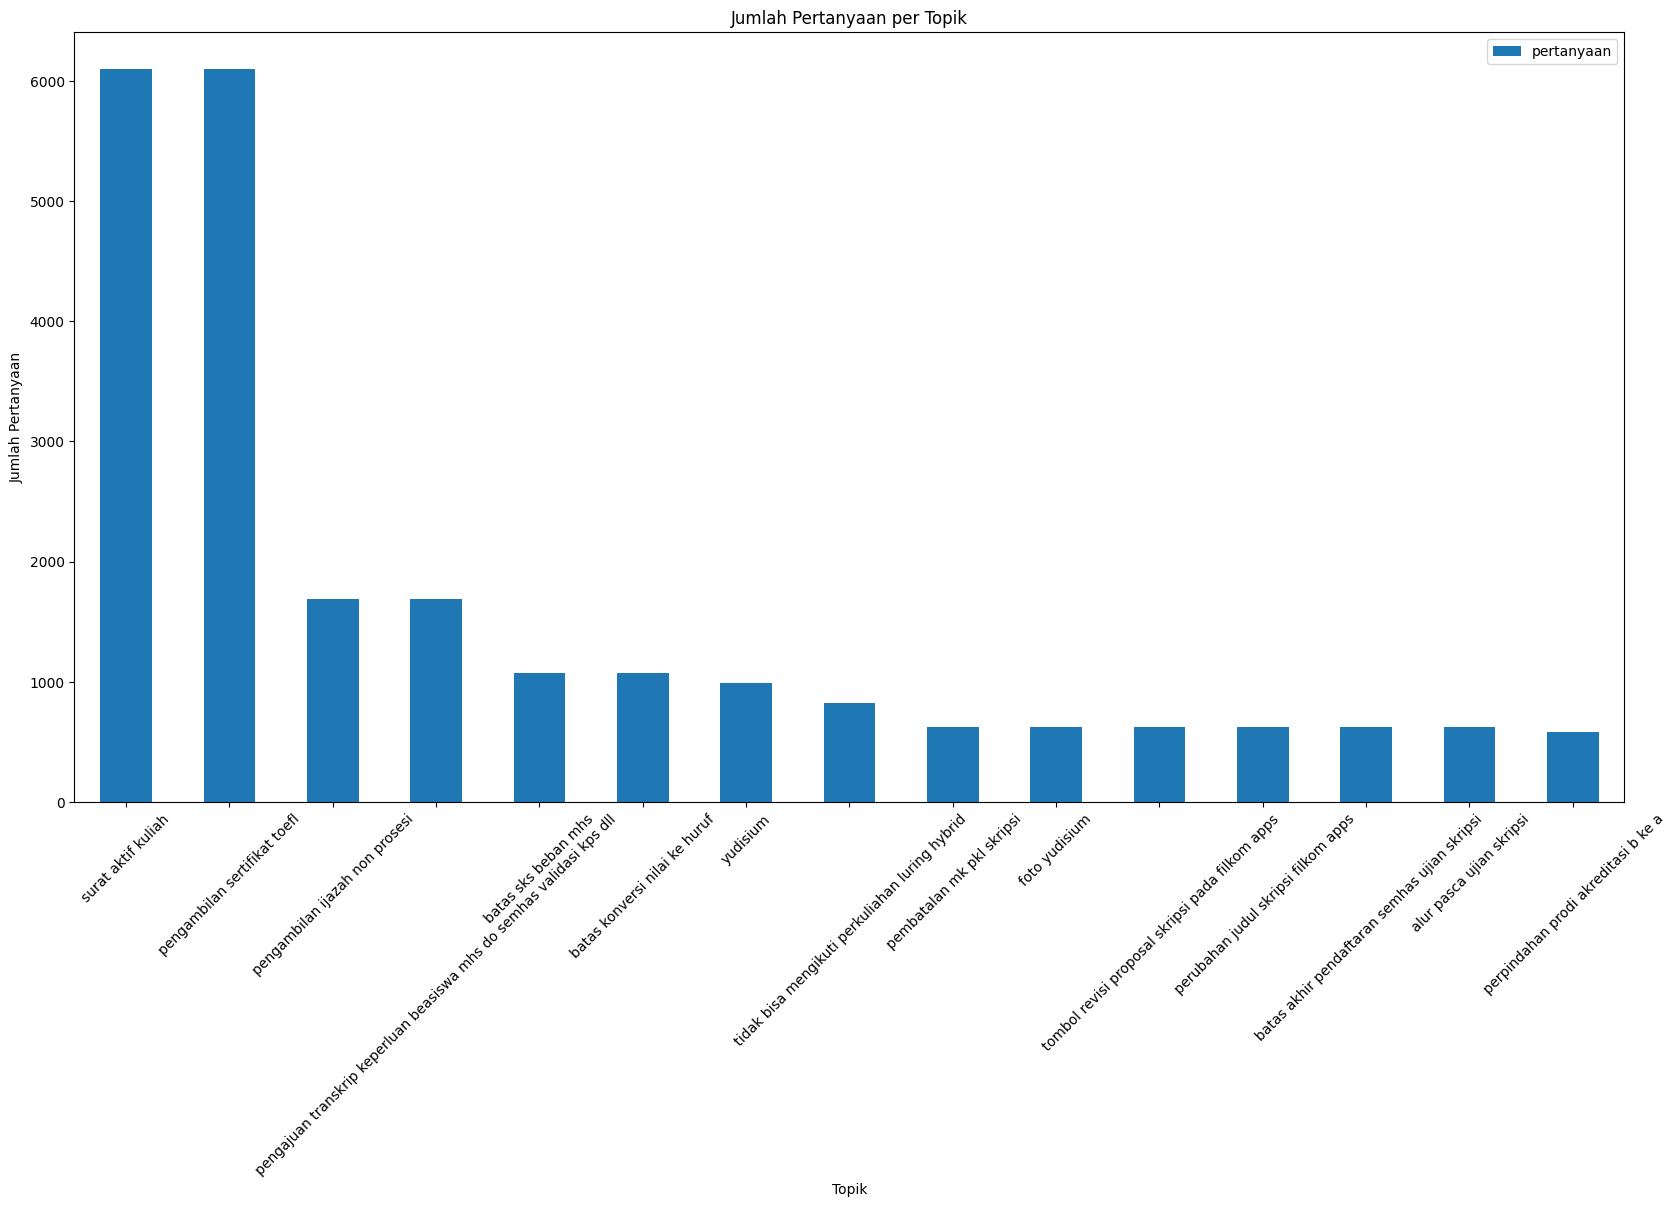

In [74]:
dfp =dfg.head(15).plot(kind='bar',
            figsize=(20,10),
            title='Jumlah Pertanyaan per Topik',
            xlabel='Topik',
            ylabel='Jumlah Pertanyaan',
            rot=45)

In [75]:
fig = dfp.get_figure()
fig.savefig("experiment_n2.png")

In [76]:
dfPertanyaan['pertanyaan'] = dfPertanyaan['pertanyaan'].apply(lambda x: x.replace('\u00a0',''))

## Intent Classification

In [126]:
# stop word preparation

nltk.download('punkt', quiet=True)
listStopword = set(nltk.corpus.stopwords.words('indonesian'))
listStopword.add('assalamualaikum')
listStopword.add('waalaikumsalam')
listStopword.add('wassalamualaikum')
listStopword.add('salam')
listStopword.add('halo')
listStopword.add('menjawab')
listStopword.add('bapak/ibu')
listStopword.add('bapak')
listStopword.add('ibu')
listStopword.add('mengganggu')
listStopword.add('mohon')
listStopword.add('maaf')
listStopword.add('prodi')
listStopword.add('mahasiswa')
listStopword.add('terimakasih')
listStopword.add('terhormat')
listStopword.add('filkom')
listStopword.add('universitas')

In [127]:
intents = dict()
intents['intents'] = []

In [128]:
for j in range(15):
# for j in range(len(df)):
    index = j
    intent = dict()
    topik = " ".join(dfKeywords['topik'][index].split())
    correspPertanyaan = dfPertanyaan.index[dfPertanyaan['topik'] == topik].tolist()
    pattern_question = []
    for i in correspPertanyaan:
        text = dfPertanyaan['pertanyaan'][i]

        # remove punctuation
        text = re.sub('<.*?>', '', text)
        tokens = nltk.tokenize.word_tokenize(text.lower())
        tokens = [t for t in tokens if t not in listStopword]
        tokens = [t for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if len(t) > 2]
        text = " ".join(tokens)
        text = text.replace('selamat pagi','')
        text = text.replace('selamat siang','')
        text = text.replace('selamat sore','')
        text = text.replace('terima kasih','')
        text = text.strip()

        pattern_question.append(text)

    # remove duplicates pattern_question
    pattern_question = list(dict.fromkeys(pattern_question))

    intent['tag'] = topik.replace(' ','_').replace('__','_')
    intent['patterns'] = pattern_question
    intent['responses'] = [df['jawaban'][index]]
    intents['intents'].append(intent)


In [129]:
text_coba = ["dosen penguji memberitahukan nilai kkn memasukkan siam",
                "dosen penguji memberitahukan nilai kkn memasukkan siam",'tes']
text_coba = list(dict.fromkeys(text_coba))
text_coba

['dosen penguji memberitahukan nilai kkn memasukkan siam', 'tes']

### Add intent salam, tutup, no_respon

In [130]:
salam_intent = {
            "tag":"sapaan",
            "patterns": [
                "halo",
                "selamat siang",
                "selamat malam",
                "selamat pagi",
                "salam"
            ],
            "responses": [
                "Halo, saya disini HaloFILKOM Bot akan membantu anda dalam menjawab pertanyaan anda untuk urusan kemahasiswaan dan akademik."
            ]
        }
intents['intents'].append(salam_intent)

penutup_intent = {
            "tag":"penutup",
            "patterns": [
                "terima kasih",
                "menjawab",
                "sudah menjawab",
                "cukup"
            ],
            "responses": [
                "Terima kasih telah menggunakan layanan HaloFILKOM Bot, jika ada hal hal yang ingin ditanyakan lebih lanjut jangan ragu menghubungi saya lagi. Have a good day."
            ]
        }
intents['intents'].append(penutup_intent)


no_res_intent = {
            "tag":"no_response",
            "patterns": [],
            "responses": [
                "Pertanyaan belum saya kenali... silahkan menghubungi unit terkait untuk menjawab pertanyaan tersebut di HaloFILKOM. Anda juga dapat menambahkan pertanyaan anda pada <a href='https://s.ub.ac.id/tanyafilkombot' target='_blank'>laman berikut</a> untuk membantu mengembangkan sistem ini"
            ]
        }
intents['intents'].append(no_res_intent)

### Export intent to json

In [131]:
import json

with open ('intents_top15.json', 'w') as outfile: 
# with open ('intents_tes50.json', 'w') as outfile: 
# with open ('intents_coba.json', 'w') as outfile:
    json.dump(intents, outfile)